# Setup

In [1]:
import warnings
warnings.filterwarnings('ignore') #beware

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    KBinsDiscretizer, 
    FunctionTransformer,
    MinMaxScaler,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    validation_curve, 
    KFold,
)
from sklearn.metrics import (
    plot_confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    f1_score,
)

# Load data

In [2]:
app_train = pd.read_csv('data/application_train.csv')

In [3]:
for column in app_train.columns:
    print(column)

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APART

# Split data

In [4]:
X = app_train
y = app_train["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    random_state=84, \
                                                    stratify = X[["TARGET"]])

In [5]:
X_train.shape, y_train.shape

((230633, 122), (230633,))

In [6]:
X_test.shape, y_test.shape

((76878, 122), (76878,))

# Pre-process

### Custom functions for some variables

In [7]:
def abs_log(a):
    """
    This function takes the absolute value and then applies a log transformation. Absolute
    values are necessary as the values are negative and log transformation coult not be 
    applied. Log transformation is applied to make the variables more normally distributed
    while keeping ease of interpretation.
    """
    a = a.iloc[:, 0]
    a = abs(a)
    a = np.log(a)
    a = np.array(a).reshape(-1, 1)
    return a

In [8]:
def winsorize_and_log(a):
    """
    This function winsorizes at 1% and 99% of the distribution to handle outliers which are 
    clearly wrong and not reduce the sample size. A log of the variable is taken after 
    winsorizing to get the distribution closer to a normal distribution while keeping ease
    of interpretation.
    """
    a = a.iloc[:, 0]
    a = winsorize(a, limits = [.01, .01])
    a = np.log(a)
    a = np.array(a).reshape(-1, 1)
    return a

In [9]:
def categorize_education_type(a):
    """
    This function splits people into having higher education or not. This is done to reduce the
    amount of categories while still being meaningful.
    """
    a = a.iloc[:, 0]
    a = [1 if d == "Secondary / secondary special|Lower secondary" else 0 for d in a]
    a = np.array(a).reshape(-1, 1)
    return a

In [10]:
def categorize_income_type(a):
    """
    This function splits people into being active workers or not. Grouping is necessary here as 
    otherwise we would need to delete the Maternity leave/Businessman group as there are very few
    observations for these categories. When doing the split, these categories cause issues.
    """
    a = a.iloc[:, 0]
    a = [1 if d == "Working|Commercial associate|State servant|Businessman" else 0 for d in a]
    a = np.array(a).reshape(-1, 1)
    return a

In [11]:
def categorize_family_status(a):
    """
    This function splits people into being alone or not. Grouping is necessary here as otherwise 
    we would need to delete the Unknown group as there are only 2 observations for that category.
    When doing the split, this very small category causes issues.
    """
    a = a.iloc[:, 0]
    a = [1 if d == "Married|Civil marriage" else 0 for d in a]
    a = np.array(a).reshape(-1, 1)
    return a

### Column transformations

In [12]:
ct = ColumnTransformer(
    [
        ( # Bora, Maha
            "dummies", OneHotEncoder(), 
            ["NAME_HOUSING_TYPE", "NAME_CONTRACT_TYPE"]
        ), 
        
        ( # Bora
            "logs", FunctionTransformer(np.log), 
             ["AMT_ANNUITY"]
        ), 
        
        ( # Kahmin
            "abs_logs", FunctionTransformer(abs_log), 
             ["DAYS_BIRTH"]
        ), 
        
        ( # Maha
            "winsorized_log", FunctionTransformer(winsorize_and_log), 
            ["AMT_INCOME_TOTAL"]
        ),
        
        ( # Lennard
            "higher_education", FunctionTransformer(categorize_education_type), 
            ["NAME_EDUCATION_TYPE"]
        ), 
        
        ( # Kahmin
            "alone", FunctionTransformer(categorize_family_status), 
            ["NAME_FAMILY_STATUS"]
        ), 
        
        ( # Sailan
            "active_employment", FunctionTransformer(categorize_income_type), 
            ["NAME_INCOME_TYPE"]
        ), 
        
        ( # Sailan
            "minmax", MinMaxScaler(),
            ["AMT_CREDIT"]
        ), 
        
        ( # Kahmin
            "passthroughs", "passthrough",
            ["CNT_FAM_MEMBERS"]
        ), 
    ]
)

In [13]:
X_train_processed = pd.DataFrame(ct.fit_transform(X_train))
X_test_processed = pd.DataFrame(ct.fit_transform(X_test))

In [14]:
X_train_processed.shape, X_test_processed.shape

((230633, 16), (76878, 16))

### Prepare y-vector

In [15]:
y_train_processed = y_train.reset_index(drop=True)
y_test_processed = y_test.reset_index(drop=True)

In [16]:
y_train_processed.shape, y_test_processed.shape

((230633,), (76878,))

# Clean

### Correct for remaining missing values

In [17]:
index_train = (X_train_processed.isna().sum(axis=1)) | (y_train.isna())
index_test = (X_test_processed.isna().sum(axis=1)) | (y_test.isna())

In [18]:
X_train_processed_cleaned = X_train_processed[-index_train]
y_train_processed_cleaned = y_train_processed[-index_train]

X_test_processed_cleaned = X_test_processed[-index_test]
y_test_processed_cleaned = y_test_processed[-index_test]

/tmp/ipykernel_100203/1885464961.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_processed_cleaned = X_train_processed[-index_train]
/tmp/ipykernel_100203/1885464961.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_processed_cleaned = X_test_processed[-index_test]


In [19]:
X_train_processed_cleaned.shape, X_test_processed_cleaned.shape

((230620, 16), (76877, 16))

In [20]:
y_train_processed_cleaned.shape, y_test_processed_cleaned.shape

((230620,), (76877,))

# Model

In [28]:
log_reg = LogisticRegression()

log_reg.fit(X_train_processed_cleaned, y_train_processed_cleaned)

/home/lennard/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Evaluate

/home/lennard/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


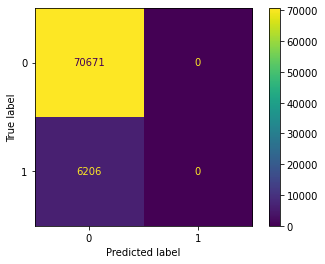

In [29]:
plot_confusion_matrix(log_reg, X_test_processed_cleaned, y_test_processed_cleaned)

## Kfold validation

In [38]:
accuracies = []
model = []

kf = KFold(n_splits=10)
kf.get_n_splits(X_train)

X = X_train.reset_index(drop = True)
y = y_train.reset_index(drop = True)

for train_fold, test_fold in kf.split(X_train):

    # split
    X_train_fold, X_test_fold = X.iloc[train_fold], X.iloc[test_fold]
    y_train_fold, y_test_fold = y[train_fold], y[test_fold]
    
    # transform
    X_train_fold_processed = pd.DataFrame(ct.fit_transform(X_train_fold))
    X_test_fold_processed = pd.DataFrame(ct.fit_transform(X_test_fold)) 
    y_train_fold_processed = y_train_fold.reset_index(drop=True)
    y_test_fold_processed = y_test_fold.reset_index(drop=True)
    
    # clean
    index_train = (X_train_fold_processed.isna().sum(axis=1)) | (y_train_fold_processed.isna())
    index_test = (X_test_fold_processed.isna().sum(axis=1)) | (y_test_fold_processed.isna())
    X_train_fold_processed_cleaned = X_train_fold_processed[-index_train]
    y_train_fold_processed_cleaned = y_train_fold_processed[-index_train]
    X_test_fold_processed_cleaned = X_test_fold_processed[-index_test]
    y_test_fold_processed_cleaned = y_test_fold_processed[-index_test]

    # model
    lr = LogisticRegression()
    lr.fit(X_train_fold_processed_cleaned, y_train_fold_processed_cleaned)

    # save
    model.append(lr)
    accuracies.append(accuracy_score(lr.predict(X_test_fold_processed_cleaned), y_test_fold_processed_cleaned))


/home/lennard/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lennard/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres